# Example of the Basic HMM Approach

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from datetime import datetime, timedelta
import pytz

In [2]:
import sys
sys.path.append('../hidden_regime')
import hidden_regime as hr
from hidden_regime import HiddenMarkovModel, HMMConfig

## Data Collection

In [3]:
TICKER = 'MSFT'
NUM_STATES = 4
START_DATE = '2024-01-01'
END_DATE = '2024-09-02'
RANDOM_SEED = 4242

In [4]:
data = hr.load_stock_data(TICKER, START_DATE, END_DATE)

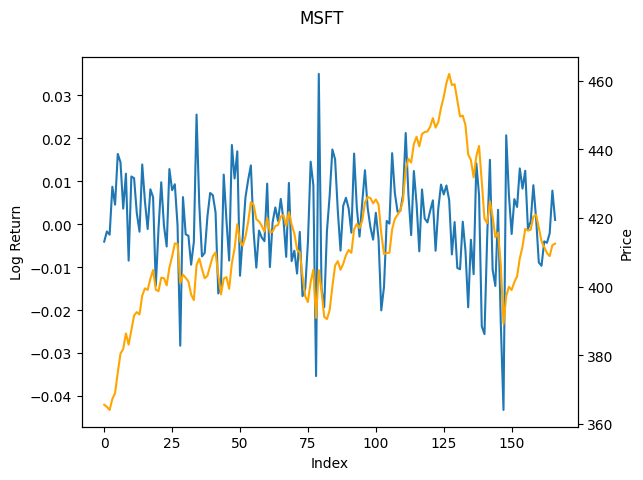

In [5]:
fig = plt.figure()
ax = data.log_return.plot()
ax.set_ylabel('Log Return')
ax.set_xlabel('Index')
ax2 = ax.twinx()
ax2.set_ylabel('Price')
_ = data.price.plot(ax=ax2, color='orange')
_ = fig.suptitle(TICKER)

## HMM Setup

In [11]:
config = HMMConfig(
    n_states=NUM_STATES,
    max_iterations=100,
    tolerance=1e-6,
    initialization_method='kmeans',
    random_seed=RANDOM_SEED
)

print(config)

HMMConfig(n_states=4, max_iterations=100, tolerance=1e-06, regularization=1e-06, initialization_method='kmeans', random_seed=4242, min_regime_duration=2, min_variance=1e-08, check_convergence_every=5, early_stopping=True, log_likelihood_threshold=-10000000000.0, regime_type='3_state', auto_select_states=False, state_validation_threshold=0.7, force_state_ordering=True, validate_regime_economics=True)


/mnt/c/Workspace/hidden-regime/hidden_regime/models/config.py:85: UserWarning: Setting n_states to 3 based on regime_type='3_state'
  warnings.warn(f"Setting n_states to {expected_states} based on regime_type='{self.regime_type}'")


In [7]:
hmm = HiddenMarkovModel(config=config)

In [8]:
hmm.fit(data.log_return, verbose=True)

Training 3-state HMM on 167 observations
Max iterations: 100, Tolerance: 1e-06
Iteration 0: Log-likelihood = 521.9086, Improvement = inf
Iteration 10: Log-likelihood = 529.3021, Improvement = 0.108256
Iteration 20: Log-likelihood = 529.7699, Improvement = 0.030723
Iteration 30: Log-likelihood = 529.9832, Improvement = 0.014209
Iteration 40: Log-likelihood = 530.0697, Improvement = 0.005383
Iteration 50: Log-likelihood = 530.1048, Improvement = 0.002511
Iteration 60: Log-likelihood = 530.1253, Improvement = 0.001859
Iteration 70: Log-likelihood = 530.1443, Improvement = 0.002001
Iteration 80: Log-likelihood = 530.1662, Improvement = 0.002341
Iteration 90: Log-likelihood = 530.1910, Improvement = 0.002578
Applied state standardization and ordering
Regime validation confidence: 0.921
Training completed in -2.31s
Final log-likelihood: 530.2146


/mnt/c/Workspace/hidden-regime/hidden_regime/models/base_hmm.py:267: UserWarning: HMM did not converge after 100 iterations. Final improvement: 0.002632
  warnings.warn(


HiddenMarkovModel(n_states=3, fitted=True, log_likelihood=530.21)

In [9]:
hmm.initial_probs_

array([1.19538718e-06, 9.99997328e-01, 1.47627217e-06])

In [10]:
for i in range(NUM_STATES):
    mean, std = hmm.emission_params_[i]
    print(f"     State {i}: mean={mean:.4f}, std={std:.4f}")

     State 0: mean=-0.0107, std=0.0129
     State 1: mean=0.0030, std=0.0077
     State 2: mean=0.0036, std=0.0148


IndexError: index 3 is out of bounds for axis 0 with size 3

In [ ]:
hmm.transition_matrix_

## HMM State Prediction

In [ ]:
predicted_states = hmm.predict(data.log_return)
state_probabilities = hmm.predict_proba(data.log_return)

In [ ]:
price = data.set_index(data.date).price

In [ ]:
predicted_state = pd.Series(
    index=data.date, 
    data=predicted_states, 
    name=f'{TICKER}_Predicted_States')

state_probability = pd.DataFrame(
    index=data.date, 
    data=state_probabilities)

In [ ]:
latest = predicted_state.index[-1]
output_format = "%m/%d/%Y"
formatted_date = latest.strftime(output_format)
current_state = predicted_state[latest]
mean, std = hmm.emission_params_[current_state]
print(f'Current state for {formatted_date} is: {current_state} (Mean: {mean:.4f}, Std: {std:.4f})')

## Data Visualization

In [ ]:
fig = plt.figure()
ax = predicted_state.plot.line()
plt.yticks(list(range(NUM_STATES)))
ax.set_ylabel('State')
ax2 = ax.twinx()
_ = price.plot(ax=ax2, color='orange', style='--')
ax2.set_ylabel('Price')
_ = fig.suptitle(f'State Estimate for {TICKER}')

In [ ]:
fig2 = plt.figure()
ax = state_probability.plot.line()
ax.set_ylabel('State Probability')
ax2 = ax.twinx()
_ = price.plot(ax=ax2, color='orange', style='--')
_= ax2.set_ylabel('Price')
_ = fig2.suptitle(f'State Probability Estimate for {TICKER}')

In [ ]:
# Assuming 'price' and 'predicted_state' are pandas Series with datetime indexes
# and ax2 is the correct axes object for the price data.

plt.figure(figsize=(12, 8))
ax = price.plot(color='black')
legend_handles = []
legend_labels = []

unique_states = predicted_state.unique()
for state in unique_states:
    
    mean, std = hmm.emission_params_[state]
    if mean > 0.0005:
        color='blue'
    else:
        color='red'
        
    # Create a boolean mask to filter data for the current state
    is_state_active = (predicted_state == state)

    # Use fill_between to shade the area under the price curve
    ax.fill_between(
        x=price.index,
        y1=price,  # The price curve
        y2=0,      # The x-axis (or another base line)
        where=is_state_active,
        facecolor=color,
        alpha=0.6  # Set transparency
    )

    # Create a legend handle (a colored patch) for the current state
    patch = mpatches.Patch(color=color, 
                           label=f'State {state}')
    legend_handles.append(patch)
    legend_labels.append(f'State {state} ({mean:.4f})')

# Add the legend to the price axis
ax.legend(handles=legend_handles, labels=legend_labels)
ax.set_ylabel('Price')
ax.set_xlabel('Date')

plt.title(f'Predicted State for {TICKER} based on Price')

plt.show()

## How it really plays out...

In [ ]:
OUTLOOK = timedelta(days=60)
FUTURE_DATE = latest + OUTLOOK
future_formatted_date = FUTURE_DATE.strftime(output_format)
print(f'Examine results from {formatted_date} to {future_formatted_date}')

In [ ]:
future_data = hr.load_stock_data(TICKER, END_DATE, FUTURE_DATE.replace(tzinfo=None))
price_change = np.log(future_data.price / data.price.iloc[-1])

In [ ]:
fig = plt.figure()
ax = price_change.plot()
ax.set_ylabel(f'Log Return from {formatted_date}')
ax.set_xlabel('Index')
_ = fig.suptitle(f'Future Data for {TICKER}')